In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import time 
import tqdm
from PIL import Image
train_on_gpu = True
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

from collections import OrderedDict
import cv2

import albumentations
import torch as AT
import pretrainedmodels

from torch.optim import SGD

In [2]:
train_df = pd.read_csv("D:\\桌面\\humpback-whale-identification\\train.csv")
train_df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [3]:
train_dir = 'D:\\桌面\\humpback-whale-identification\\train'
test_dir = 'D:\\桌面\\humpback-whale-identification\\test'

print(f'训练数据集中有 {len(os.listdir(train_dir))} 张图像，涵盖 {train_df.Id.nunique()} 个独特类别。')
print(f'测试数据集中有 {len(os.listdir(test_dir))} 张图像。')

训练数据集中有 25361 张图像，涵盖 5005 个独特类别。
测试数据集中有 7960 张图像。


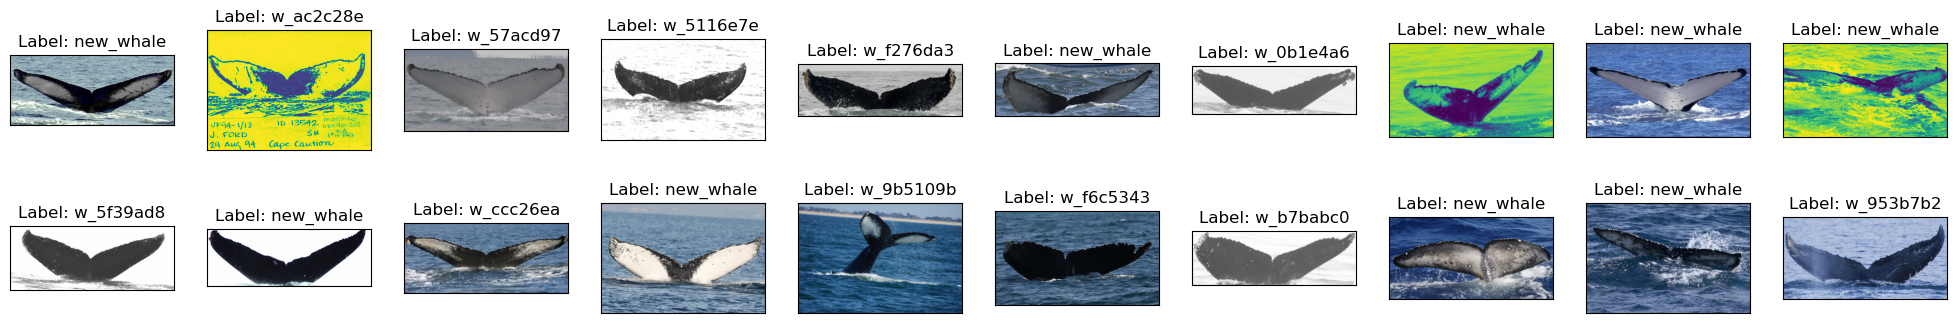

In [4]:
fig = plt.figure(figsize=(25, 4))
train_imgs = os.listdir("D:\\桌面\\humpback-whale-identification\\train")
train_path = "D:\\桌面\\humpback-whale-identification\\train"  # 修改为您的实际路径
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open(os.path.join(train_path, img))
    plt.imshow(im)
    lab = train_df.loc[train_df.Image == img, 'Id'].values[0]
    ax.set_title(f'Label: {lab}')
plt.show()

In [5]:
train_df.Id.value_counts().head()

Id
new_whale    9664
w_23a388d      73
w_9b5109b      65
w_9c506f6      62
w_0369a5c      61
Name: count, dtype: int64

In [6]:
for i in range(1, 4):
    print(f'There are {train_df.Id.value_counts()[train_df.Id.value_counts().values==i].shape[0]} classes with {i} samples in train data.')

There are 2073 classes with 1 samples in train data.
There are 1285 classes with 2 samples in train data.
There are 568 classes with 3 samples in train data.


<Axes: title={'center': 'Distribution of classes excluding new_whale'}, ylabel='Frequency'>

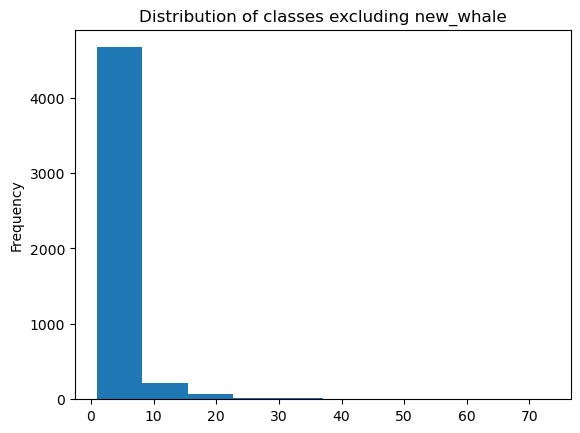

In [7]:
plt.title('Distribution of classes excluding new_whale')
train_df.Id.value_counts()[1:].plot(kind='hist')

In [8]:
np.array(im).shape

(525, 1050, 3)

In [9]:
data_transforms = transforms.Compose([
                                      transforms.Resize((100, 100)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])
    ])
data_transforms_test = transforms.Compose([
                                           transforms.Resize((100, 100)),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                 std=[0.229, 0.224, 0.225])
])

In [10]:
def prepare_labels(y):
    # From here: https://www.kaggle.com/pestipeti/keras-cnn-starter
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    y = onehot_encoded
    return y, label_encoder

In [11]:
y, le = prepare_labels(train_df['Id'])

c:\Users\yu_code\anaconda3\envs\pytorch_gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [12]:
class WhaleDataset(Dataset):
    def __init__(self, datafolder, datatype='train', df=None, transform = transforms.Compose([transforms.ToTensor()]), y=None):
        self.datafolder = datafolder
        self.datatype = datatype
        self.y = y
        if self.datatype == 'train':
            self.df = df.values
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform


    def __len__(self):
        return len(self.image_files_list)
    
    def __getitem__(self, idx):
        if self.datatype == 'train':
            img_name = os.path.join(self.datafolder, self.df[idx][0])
            label = self.y[idx]
            
        elif self.datatype == 'test':
            img_name = os.path.join(self.datafolder, self.image_files_list[idx])
            label = np.zeros((5005,))

        image = Image.open(img_name).convert('RGB')
        image = self.transform(image)
        if self.datatype == 'train':
            return image, label
        elif self.datatype == 'test':
            # so that the images will be in a correct order
            return image, label, self.image_files_list[idx]

In [13]:
train_dataset = WhaleDataset(datafolder='D:\\桌面\\humpback-whale-identification\\train', datatype='train', df=train_df, transform=data_transforms, y=y)
test_set = WhaleDataset(datafolder='D:\\桌面\\humpback-whale-identification\\test', datatype='test', transform=data_transforms_test)

In [14]:
train_sampler = SubsetRandomSampler(list(range(len(os.listdir('D:\\桌面\\humpback-whale-identification\\train')))))
valid_sampler = SubsetRandomSampler(list(range(len(os.listdir('D:\\桌面\\humpback-whale-identification\\test')))))
batch_size = 512
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
# less size for test loader.
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, num_workers=num_workers)

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 7, padding=1)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)        
        self.pool2 = nn.AvgPool2d(3, 3)
        
        self.fc1 = nn.Linear(64 * 4 * 4 * 16, 1024)
        self.fc2 = nn.Linear(1024, 5005)

        self.dropout = nn.Dropout(0.5)        

    def forward(self, x):
        x = self.pool(F.relu(self.conv2_bn(self.conv1(x))))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 4 * 4 * 16)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [16]:
model_conv = Net()

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model_conv.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# 定义空列表来收集损失和准确率
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# 设置epochs数量
n_epochs = 10

# 减小批次大小
batch_size = 128

# 创建新的数据加载器
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)

# 修改模型结构，减少参数数量
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 25 * 25, 512)
        self.fc2 = nn.Linear(512, 5005)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 25 * 25)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# 将模型移到GPU
model_simple = SimpleNet().cuda()

# 修改优化器和学习率调度器
optimizer = optim.Adam(model_simple.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# 训练循环
for epoch in range(1, n_epochs + 1):
    print(time.ctime(), 'Epoch:', epoch)

    train_loss = []
    correct = 0
    total = 0

    exp_lr_scheduler.step()

    for batch_i, (data, target) in enumerate(tqdm(train_loader, desc=f"第 {epoch} 次迭代")):
        data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model_simple(data)
        loss = criterion(output, target.float())
        train_loss.append(loss.item())

        # # 修改计算准确率的部分
        # _, predicted = torch.max(output.data, 1)
        # predicted = predicted.view(-1)  # 将predicted张量的形状调整为一维
        # total += target.size(0)
        # print("Predicted shape:", predicted.shape)
        # print("Target shape:", target.shape)
        # correct += (predicted == target).sum().item()
        # 修改计算准确率的部分
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        predicted = predicted.view(-1, 1)  # 将predicted张量的形状调整为与target相同
        correct += (predicted == target.argmax(dim=1, keepdim=True)).sum().item()


        loss.backward()
        optimizer.step()

    epoch_loss = np.mean(train_loss)
    epoch_accuracy = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f'第 {epoch} 次迭代，训练损失: {epoch_loss:.4f}，训练准确率: {epoch_accuracy:.4f}')

# 训练循环
for epoch in range(1, n_epochs + 1):
    print(time.ctime(), 'Epoch:', epoch)

    test_loss = []
    correct = 0
    total = 0

    exp_lr_scheduler.step()

    for batch_i, (data, target) in enumerate(tqdm(test_loader, desc=f"第 {epoch} 次迭代")):
        data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model_simple(data)
        loss = criterion(output, target.float())
        train_loss.append(loss.item())

        # # 修改计算准确率的部分
        # _, predicted = torch.max(output.data, 1)
        # predicted = predicted.view(-1)  # 将predicted张量的形状调整为一维
        # total += target.size(0)
        # print("Predicted shape:", predicted.shape)
        # print("Target shape:", target.shape)
        # correct += (predicted == target).sum().item()
        # 修改计算准确率的部分
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        predicted = predicted.view(-1, 1)  # 将predicted张量的形状调整为与target相同
        correct += (predicted == target.argmax(dim=1, keepdim=True)).sum().item()


        loss.backward()
        optimizer.step()

    epoch_loss = np.mean(train_loss)
    epoch_accuracy = correct / total
    test_losses.append(epoch_loss)
    test_accuracies.append(epoch_accuracy)

    print(f'第 {epoch} 次迭代，训练损失: {epoch_loss:.4f}，训练准确率: {epoch_accuracy:.4f}')


# 读取样本提交文件
sub = pd.read_csv('D:\\桌面\\humpback-whale-identification\\sample_submission.csv')

# 测试循环
for (data, target, name) in tqdm(test_loader, desc="测试"):
    data = data.cuda()
    output = model_simple(data)
    output = output.cpu().detach().numpy()
    for i, (e, n) in enumerate(list(zip(output, name))):
        sub.loc[sub['Image'] == n, 'Id'] = ' '.join(le.inverse_transform(e.argsort()[-5:][::-1]))



In [ ]:
# 训练循环
for epoch in range(1, n_epochs + 1):
    print(time.ctime(), 'Epoch:', epoch)

    test_loss = []
    correct = 0
    total = 0

    exp_lr_scheduler.step()

    for batch_i, (data, target) in enumerate(tqdm(test_loader, desc=f"第 {epoch} 次迭代")):
        data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model_simple(data)
        loss = criterion(output, target.float())
        test_loss.append(loss.item())

        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        loss.backward()
        optimizer.step()

    epoch_loss = np.mean(test_loss)
    epoch_accuracy = correct / total
    test_losses.append(epoch_loss)
    test_accuracies.append(epoch_accuracy)

    print(f'第 {epoch} 次迭代，训练损失: {epoch_loss:.4f}，训练准确率: {epoch_accuracy:.4f}')

In [ ]:
# 将预测保存到CSV文件中
sub.to_csv('basic_model.csv', index=False)

# Plot loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epoch + 1), train_losses, label='Train Loss')
plt.plot(range(1,epoch+1),test_losses,label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epoch + 1), train_accuracies, label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
class WhaleDataset(Dataset):
    def __init__(self, datafolder, datatype='train', df=None, transform = transforms.Compose([transforms.ToTensor()]), y=None
                ):
        self.datafolder = datafolder
        self.datatype = datatype
        self.y = y
        if self.datatype == 'train':
            self.df = df.values
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform


    def __len__(self):
        return len(self.image_files_list)
    
    def __getitem__(self, idx):
        if self.datatype == 'train':
            img_name = os.path.join(self.datafolder, self.df[idx][0])
            label = self.y[idx]
            
        elif self.datatype == 'test':
            img_name = os.path.join(self.datafolder, self.image_files_list[idx])
            label = np.zeros((5005,))

        img = cv2.imread(img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image = self.transform(image=img)
        image = image['image']
        if self.datatype == 'train':
            return image, label
        elif self.datatype == 'test':
            # so that the images will be in a correct order
            return image, label, self.image_files_list[idx]

In [ ]:
import albumentations as A
from torchvision import transforms

data_transforms = A.Compose([
    A.Resize(160, 320),
    A.HorizontalFlip(),
    A.RandomBrightness(),
    A.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
    A.JpegCompression(80),
    A.HueSaturationValue(),
    A.Normalize(),
])

data_transforms_test = A.Compose([
    A.Resize(160, 320),
    A.Normalize(),
])

train_dataset = WhaleDataset(
    datafolder='D:\\桌面\\humpback-whale-identification\\train',
    datatype='train',
    df=train_df,
    transform=data_transforms,
    y=y
)


In [ ]:
model_conv = torchvision.models.resnet101(pretrained=True)
for i, param in model_conv.named_parameters():
    param.requires_grad = False

In [ ]:
final_layer = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 1024)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(0.1)),
                          ('fc2', nn.Linear(1024, 5005)),
                          ]))
model_conv.fc = final_layer
model_conv.fc = nn.Linear(2048, 5005)

In [ ]:
model_conv = pretrainedmodels.resnext101_64x4d()
model_conv.avg_pool = nn.AvgPool2d((5,10))
model_conv.last_linear = nn.Linear(model_conv.last_linear.in_features, 5005)

In [ ]:
model_conv.cuda()
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model_conv.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
n_epochs = 4
for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)

    train_loss = []
    

    for batch_i, (data, target) in enumerate(train_loader):
        # print(f'Batch {batch_i} of 50')
        data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model_conv(data)
        loss = criterion(output, target.float())
        train_loss.append(loss.item())

        loss.backward()
        optimizer.step()
    exp_lr_scheduler.step()

    print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}')

In [ ]:
sub = pd.read_csv('../input/sample_submission.csv')

model_conv.eval()
for (data, target, name) in test_loader:
    data = data.cuda()
    output = model_conv(data)
    output = output.cpu().detach().numpy()
    for i, (e, n) in enumerate(list(zip(output, name))):
        sub.loc[sub['Image'] == n, 'Id'] = ' '.join(le.inverse_transform(e.argsort()[-5:][::-1]))
        
sub.to_csv('submission.csv', index=False)